# Imports

In [20]:
import numpy as np
import pandas as pd
import pylab as p
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import tensorflow as tf
from tensorflow import keras

# Functions Definitions

In [21]:
# display matrix matrix function
def display_metrics_and_confusion_matrix(model_name, y_true, y_pred):
    """
    Displays accuracy, classification report (as a DataFrame), and a confusion matrix heatmap.
    """
    acc = accuracy_score(y_true, y_pred)

    # Convert classification report to DataFrame
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).T

    # Print accuracy
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")

    # Display the classification report as a DataFrame
    display(report_df.style.background_gradient(cmap="Blues").format("{:.2f}"))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

In [22]:

###############################################################################
# 1. DATA LOADING & PREPROCESSING
###############################################################################
# --- Load MNIST from Keras ---
"""
Loads the MNIST dataset from Keras, flattens the images from (28,28) to (784,),
normalizes pixel values to [0,1], and (optionally) reduces dimensionality using PCA.

Arguments:
    use_pca (bool): Whether to apply PCA for dimensionality reduction.
    pca_variance (float): The variance ratio to keep when applying PCA. E.g., 0.95.

Returns:
    X_train, X_test: Feature arrays (train/test).
    y_train, y_test: Label arrays (train/test).
"""
def load_and_preprocess_data(use_pca=False, pca_variance=0.95):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_train = X_train.reshape((X_train.shape[0], 28 * 28)).astype('float32') / 255.0
    X_test = X_test.reshape((X_test.shape[0], 28 * 28)).astype('float32') / 255.0
    if use_pca:
        pca = PCA(n_components=pca_variance)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    return X_train, X_test, y_train, y_test

###############################################################################
# 2. BASELINE MODEL: SIMPLE NEURAL NETWORK
###############################################################################
def build_baseline_neural_network(input_dim, num_classes=10):
    """
    Builds a simple feed-forward neural network using Keras Sequential API.

    Arguments:
        input_dim (int): Dimensionality of input features (784 for raw MNIST, or fewer if PCA is used).
        num_classes (int): Number of output classes. Default is 10 for digits [0..9].

    Returns:
        A compiled tf.keras Sequential model.
    """
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(input_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

def train_baseline_nn(X_train, y_train, X_test, y_test, epochs=5, batch_size=128):
    """
    Trains the baseline neural network on the training data. Evaluates on the test set.

    Arguments:
        X_train, y_train: Training data and labels.
        X_test, y_test: Test data and labels.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: The trained neural network.
        test_accuracy (float): Accuracy on the test set.
    """
    input_dim = X_train.shape[1]
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(input_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    display_metrics_and_confusion_matrix("Baseline NN", y_test, y_pred)
    return model

###############################################################################
# 3. CLASSICAL MACHINE LEARNING MODELS
###############################################################################

# 3.1 KNN
def train_knn(X_train, y_train, X_test, y_test, k=3):
    """
    Trains a K-Nearest Neighbors model and evaluates on the test set.

    Arguments:
        k (int): Number of neighbors.
    """
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    display_metrics_and_confusion_matrix("KNN", y_test, y_pred)
    return knn


# 3.2 SVM
def train_svm(X_train, y_train, X_test, y_test, kernel='rbf'):
    """
    Trains a Support Vector Machine model with the specified kernel.

    Arguments:
        kernel (str): Kernel type ('linear', 'rbf', 'poly', etc.).
    """
    svm = SVC(kernel=kernel)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    display_metrics_and_confusion_matrix("SVM", y_test, y_pred)
    return svm


# 3.3 Decision Tree
def train_decision_tree(X_train, y_train, X_test, y_test, max_depth=None):
    """
    Trains a Decision Tree classifier.

    Arguments:
        max_depth (int or None): The maximum depth of the tree. If None, no maximum.
    """
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    display_metrics_and_confusion_matrix("Decision Tree", y_test, y_pred)
    return dt

# 3.4 AdaBoost
def train_adaboost(X_train, y_train, X_test, y_test, n_estimators=50):
    """
    Trains an AdaBoost classifier with decision trees as base estimators.

    Arguments:
        n_estimators (int): Number of weak learners.
    """
    ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=n_estimators, random_state=42)
    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    display_metrics_and_confusion_matrix("AdaBoost", y_test, y_pred)
    return ada


# 3.5 Random Forest
def train_random_forest(X_train, y_train, X_test, y_test, n_estimators=100):
    """
    Trains a Random Forest classifier.

    Arguments:
        n_estimators (int): Number of trees in the forest.
    """
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    display_metrics_and_confusion_matrix("Random Forest", y_test, y_pred)
    return rf

###############################################################################
# 4. OPTIONAL ENSEMBLE
###############################################################################
def train_ensemble(models, X_test, y_test):
    """
    Simple demonstration of a majority-voting ensemble.
    `models` is a list of trained (model_name, model) tuples.
    We'll do a simple majority vote on predictions.
    """
    predictions = [model.predict(X_test).reshape(-1, 1) for _, model in models]
    predictions = np.concatenate(predictions, axis=1)
    final_preds = [np.bincount(row).argmax() for row in predictions]
    display_metrics_and_confusion_matrix("Ensemble Majority Voting", y_test, final_preds)
    return np.array(final_preds)


###############################################################################
# 5. EVALUATION FUNCTIONS
###############################################################################
def print_metrics_and_confusion_matrix(model_name, y_true, y_pred):
    """
    Prints accuracy, classification report, and confusion matrix.
    """
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


In [23]:
# --- Load data with optional PCA ---
# Set use_pca=True to reduce dimensionality to 95% variance
X_train, X_test, y_train, y_test = load_and_preprocess_data(use_pca=False, pca_variance=0.95)

Epoch 1/5


C:\Program Files\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


469/469 - 4s - 9ms/step - accuracy: 0.9082 - loss: 0.3250
Epoch 2/5
469/469 - 2s - 4ms/step - accuracy: 0.9617 - loss: 0.1334
Epoch 3/5
469/469 - 2s - 4ms/step - accuracy: 0.9717 - loss: 0.0944
Epoch 4/5
469/469 - 2s - 4ms/step - accuracy: 0.9791 - loss: 0.0713
Epoch 5/5
469/469 - 2s - 5ms/step - accuracy: 0.9831 - loss: 0.0558
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== Baseline NN ===
Accuracy: 0.9736


,precision,recall,f1-score,support
0,0.99,0.98,0.99,980.00
1,0.99,0.99,0.99,1135.00
2,0.96,0.99,0.97,1032.00
3,0.96,0.98,0.97,1010.00
4,0.96,0.98,0.97,982.00
5,0.99,0.96,0.97,892.00
6,0.99,0.96,0.98,958.00
7,0.97,0.98,0.97,1028.00
8,0.97,0.96,0.96,974.00
9,0.96,0.96,0.96,1009.00


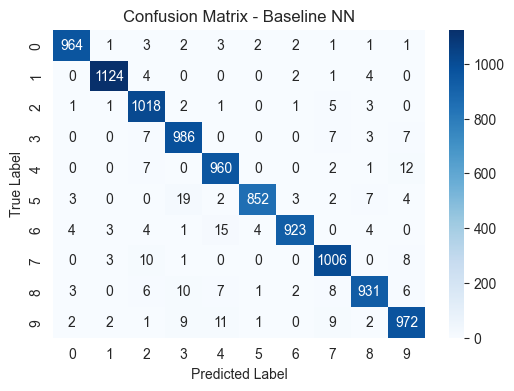

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [24]:
# --- Baseline Neural Network ---
nn_model= train_baseline_nn(X_train, y_train, X_test, y_test, epochs=5, batch_size=128)
# We can get predictions for evaluation
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)
# print_metrics_and_confusion_matrix("Baseline NN", y_test, y_pred_nn)



=== KNN ===
Accuracy: 0.9705


,precision,recall,f1-score,support
0,0.97,0.99,0.98,980.00
1,0.96,1.00,0.98,1135.00
2,0.98,0.97,0.97,1032.00
3,0.96,0.97,0.96,1010.00
4,0.98,0.97,0.97,982.00
5,0.97,0.96,0.96,892.00
6,0.98,0.99,0.98,958.00
7,0.96,0.96,0.96,1028.00
8,0.99,0.94,0.96,974.00
9,0.96,0.96,0.96,1009.00


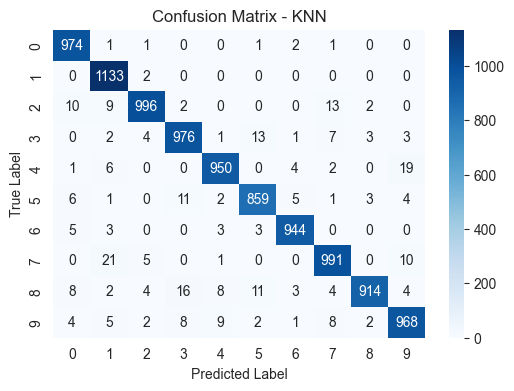

In [25]:

# --- KNN ---
knn_model = train_knn(X_train, y_train, X_test, y_test, k=3)
y_pred_knn = knn_model.predict(X_test)
# print_metrics_and_confusion_matrix("KNN", y_test, y_pred_knn)



=== SVM ===
Accuracy: 0.9792


,precision,recall,f1-score,support
0,0.98,0.99,0.99,980.00
1,0.99,0.99,0.99,1135.00
2,0.98,0.97,0.98,1032.00
3,0.97,0.99,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.99,0.98,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.98,0.97,0.97,1028.00
8,0.97,0.98,0.97,974.00
9,0.97,0.96,0.97,1009.00


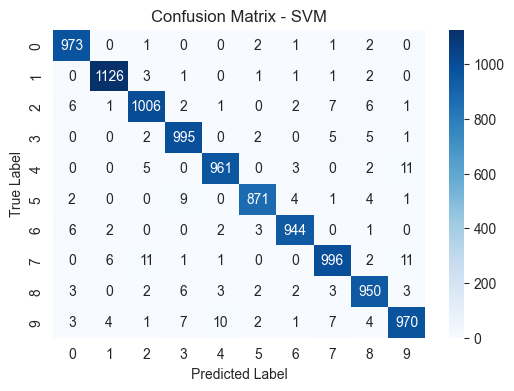

In [26]:

# --- SVM ---
svm_model = train_svm(X_train, y_train, X_test, y_test, kernel='rbf')
y_pred_svm = svm_model.predict(X_test)
# print_metrics_and_confusion_matrix("SVM (RBF)", y_test, y_pred_svm)



=== Decision Tree ===
Accuracy: 0.8663


,precision,recall,f1-score,support
0,0.91,0.94,0.92,980.00
1,0.95,0.96,0.95,1135.00
2,0.85,0.84,0.84,1032.00
3,0.82,0.84,0.83,1010.00
4,0.86,0.85,0.86,982.00
5,0.84,0.80,0.82,892.00
6,0.91,0.87,0.89,958.00
7,0.90,0.88,0.89,1028.00
8,0.80,0.81,0.80,974.00
9,0.81,0.86,0.83,1009.00


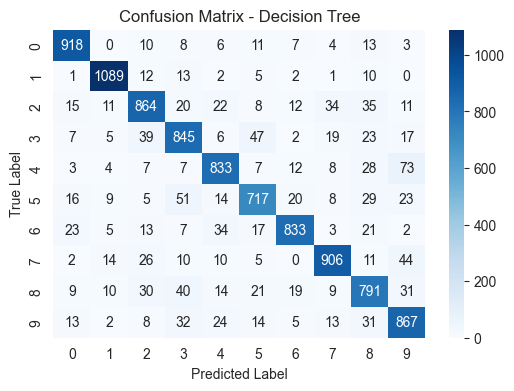

In [27]:

# --- Decision Tree ---
dt_model = train_decision_tree(X_train, y_train, X_test, y_test, max_depth=10)
y_pred_dt = dt_model.predict(X_test)
# print_metrics_and_confusion_matrix("Decision Tree", y_test, y_pred_dt)



=== AdaBoost ===
Accuracy: 0.5756


,precision,recall,f1-score,support
0,0.90,0.60,0.72,980.00
1,0.90,0.32,0.48,1135.00
2,0.56,0.67,0.61,1032.00
3,0.44,0.65,0.53,1010.00
4,0.50,0.51,0.50,982.00
5,0.46,0.50,0.48,892.00
6,0.82,0.70,0.76,958.00
7,0.69,0.60,0.64,1028.00
8,0.52,0.75,0.62,974.00
9,0.43,0.47,0.45,1009.00


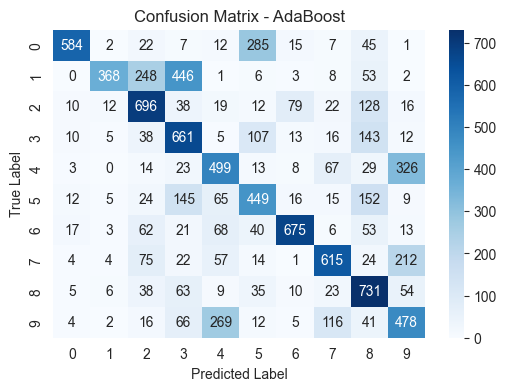

In [28]:

# --- AdaBoost ---
ada_model = train_adaboost(X_train, y_train, X_test, y_test, n_estimators=50)
y_pred_ada = ada_model.predict(X_test)



=== Random Forest ===
Accuracy: 0.9704


,precision,recall,f1-score,support
0,0.97,0.99,0.98,980.00
1,0.99,0.99,0.99,1135.00
2,0.96,0.97,0.97,1032.00
3,0.96,0.96,0.96,1010.00
4,0.97,0.97,0.97,982.00
5,0.98,0.96,0.97,892.00
6,0.98,0.98,0.98,958.00
7,0.97,0.96,0.97,1028.00
8,0.96,0.95,0.96,974.00
9,0.96,0.95,0.96,1009.00


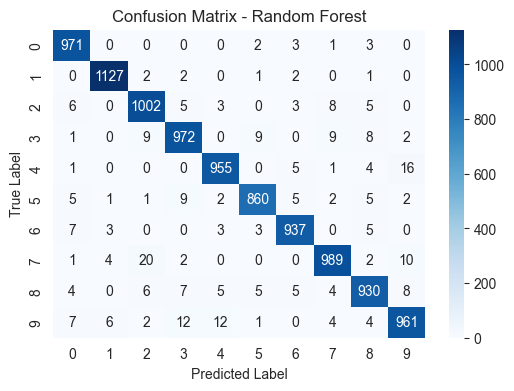

In [29]:

# --- Random Forest ---
rf_model = train_random_forest(X_train, y_train, X_test, y_test, n_estimators=100)
y_pred_rf = rf_model.predict(X_test)
# print_metrics_and_confusion_matrix("Random Forest", y_test, y_pred_rf)



=== Ensemble Majority Voting ===
Accuracy: 0.9791


,precision,recall,f1-score,support
0,0.98,0.99,0.99,980.00
1,0.99,0.99,0.99,1135.00
2,0.97,0.98,0.98,1032.00
3,0.97,0.98,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.99,0.98,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.97,0.97,0.97,1028.00
8,0.98,0.97,0.97,974.00
9,0.98,0.95,0.97,1009.00


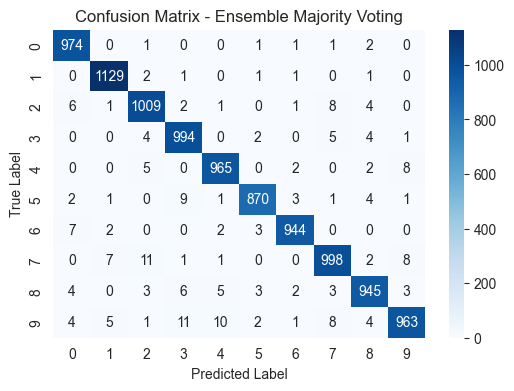

In [30]:

# --- Ensemble (Majority Voting) ---
# Here we combine the trained models above
# You can also combine fewer or more, or use VotingClassifier from sklearn
models_list = [
    ("KNN", knn_model),
    ("SVM", svm_model),
    ("SVM", svm_model),
    # ("DT", dt_model),
    # ("Ada", ada_model),
    ("RF", rf_model)
    # If desired, you can also integrate the NN by converting its predictions 
    # to a scikit-learn style predictor, but that requires a small wrapper.
]
ensemble_preds = train_ensemble(models_list, X_test, y_test)
# print_metrics_and_confusion_matrix("Ensemble Majority Voting", y_test, ensemble_preds)



=== Ensemble Majority Voting ===
Accuracy: 0.9785


,precision,recall,f1-score,support
0,0.97,0.99,0.98,980.00
1,0.98,0.99,0.99,1135.00
2,0.97,0.98,0.98,1032.00
3,0.97,0.98,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.99,0.97,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.97,0.97,0.97,1028.00
8,0.98,0.97,0.97,974.00
9,0.98,0.96,0.97,1009.00


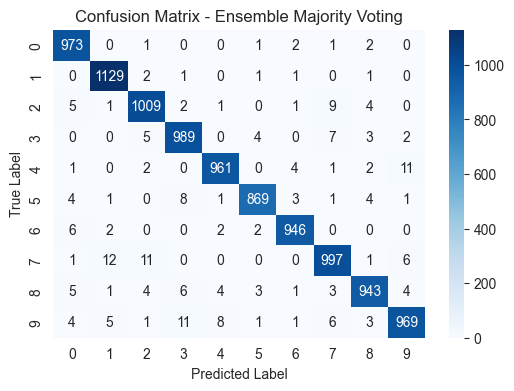

In [31]:

# --- Ensemble (Majority Voting) ---
# Here we combine the trained models above
# You can also combine fewer or more, or use VotingClassifier from sklearn
models_list = [
    ("KNN", knn_model),
    ("SVM", svm_model),
    # ("DT", dt_model),
    # ("Ada", ada_model),
    ("RF", rf_model)
    # If desired, you can also integrate the NN by converting its predictions 
    # to a scikit-learn style predictor, but that requires a small wrapper.
]
ensemble_preds = train_ensemble(models_list, X_test, y_test)
# print_metrics_and_confusion_matrix("Ensemble Majority Voting", y_test, ensemble_preds)


In [32]:

def dynamic_weighted_ensemble(models, X_test, y_test, custom_weights=None):
    """
    Combines predictions from multiple models using dynamically assigned weights per class.

    Arguments:
        models (list): List of trained models.
        X_test (array-like): Test feature set.
        y_test (array-like): True labels.
        custom_weights (list of dicts, optional): A list where each dictionary contains class-specific weights for a model.
    Returns:
        y_final_pred: Final predictions using dynamically weighted voting.
    """
    all_probs = []
    num_classes = len(np.unique(y_test))
    class_counts = np.bincount(y_test, minlength=num_classes)

    for model in models:
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)
        else:
            preds = model.predict(X_test)
            probs = np.zeros((len(preds), num_classes))
            probs[np.arange(len(preds)), preds] = 1  # Convert to one-hot
        all_probs.append(probs)

    # Use provided custom weights if available, otherwise compute class-specific weights dynamically
    weights = []
    if custom_weights:
        for w in custom_weights:
            weights.append(np.array([w.get(cls, 0) for cls in range(num_classes)]))
    else:
        for model in models:
            preds = model.predict(X_test)
            model_weights = np.zeros(num_classes)
            for cls in range(num_classes):
                model_weights[cls] = np.sum(preds == cls) / class_counts[cls] if class_counts[cls] > 0 else 0
            weights.append(model_weights)

    # Compute weighted probabilities
    final_probs = np.zeros_like(all_probs[0])
    for probs, weight in zip(all_probs, weights):
        final_probs += probs * weight  # Apply class-specific weighting

    # Get final class predictions
    y_final_pred = np.argmax(final_probs, axis=1)

    # Evaluate model performance
    display_metrics_and_confusion_matrix("Dynamic Weighted Ensemble", y_test, y_final_pred)
    return y_final_pred


In [33]:
models = [svm_model, knn_model, rf_model]  # List of trained models
# weights = [{0: 0.6, 1: 0.4, 2: 0.8}, {0: 0.5, 1: 0.5, 2: 0.7}, {0: 0.7, 1: 0.3, 2: 0.9}]  # Example weights per class
y_dynamic_weighted_ensemble = dynamic_weighted_ensemble(models, X_test, y_train)


ValueError: Found input variables with inconsistent numbers of samples: [60000, 10000]

In [52]:
# todo: change!

def dynamic_weighted_ensemble2(models, X_test, y_test, custom_weights=None):
    """
    Combines predictions from multiple models using dynamically assigned weights per class.

    Arguments:
        models (list): List of trained models.
        X_test (array-like): Test feature set.
        y_test (array-like): True labels.
        custom_weights (list of dicts, optional): A list where each dictionary contains class-specific weights for a model (weight for each classification option).

    Returns:
        y_final_pred: Final predictions using dynamically weighted voting.
    """
    if custom_weights is None:
        custom_weights = [{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1} for _ in models]

    num_classes = len(np.unique(y_test))  # Get number of unique classes dynamically

    predictions_of_models = [m.predict(X_test) for m in models]
    # Initialize the final prediction list
    final_pred = [0] * len(X_test)

    # For each instance in the test set
    for pic in range(len(X_test)):
        classify = np.zeros(num_classes)

        # Combine predictions from all models
        for model in range(len(models)):
            class_index = predictions_of_models[model][pic]
            classify[class_index] += custom_weights[model][class_index]


        # Select the class with the highest weighted sum
        max_index = 0
        for k in range(1,len(classify)):
            if classify[k] > classify[max_index]:
                max_index = k
        final_pred[pic] = max_index

    # Evaluate model performance (assuming display_metrics_and_confusion_matrix is implemented elsewhere)
    display_metrics_and_confusion_matrix("Dynamic Weighted Ensemble", y_test, final_pred)

    return final_pred





=== Dynamic Weighted Ensemble ===
Accuracy: 0.9798


,precision,recall,f1-score,support
0,0.98,0.99,0.99,980.00
1,0.99,0.99,0.99,1135.00
2,0.98,0.98,0.98,1032.00
3,0.98,0.98,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.99,0.98,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.97,0.97,0.97,1028.00
8,0.98,0.97,0.97,974.00
9,0.97,0.97,0.97,1009.00


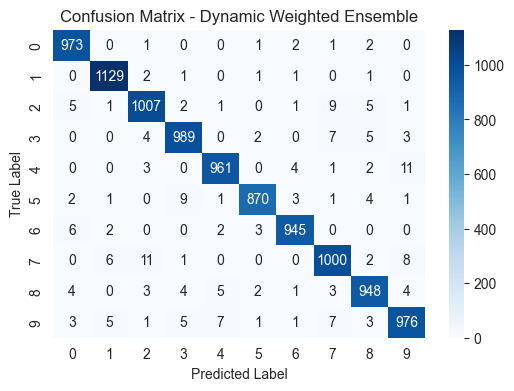

In [57]:

models = [svm_model, knn_model, rf_model]  # List of trained models
weights = [
    {0: 0.4, 1: 0.4, 2: 0.4, 3: 0.5, 4: 0.4, 5: 0.6, 6: 0.45, 7: 0.35, 8: 0.51, 9: 0.6},  # Weights for model 1
    {0: 0.3, 1: 0.1, 2: 0.45, 3: 0.4, 4: 0.3, 5: 0.1, 6: 0.45, 7: 0.45, 8: 0.3, 9: 0.5},  # Weights for model 2
    {0: 0.3, 1: 0.5, 2: 0.1, 3: 0.1, 4: 0.3, 5: 0.4, 6: 0.1, 7: 0.4, 8: 0.3, 9: 0.4}   # Weights for model 3
]

y_dynamic_weighted_ensemble = dynamic_weighted_ensemble2(models, X_test, y_test, custom_weights=weights)



=== KNN ===
Accuracy: 0.9328


,precision,recall,f1-score,support
0,0.97,1.00,0.98,980.00
1,0.97,1.00,0.98,1135.00
2,0.94,0.93,0.94,1032.00
3,0.93,0.95,0.94,1010.00
4,0.96,0.96,0.96,982.00
5,0.93,0.93,0.93,892.00
6,0.84,0.86,0.85,958.00
7,0.92,0.94,0.93,1028.00
8,0.99,0.91,0.95,974.00
9,0.86,0.86,0.86,1009.00


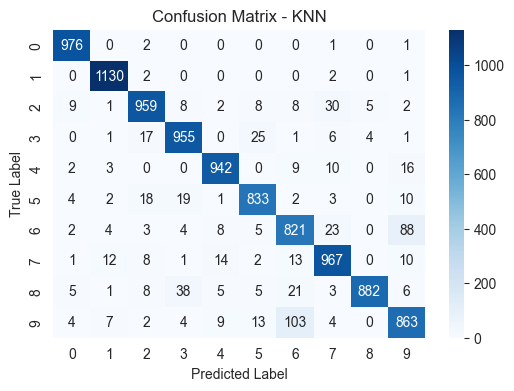

In [35]:
import importlib
import models

import transformations as trans; importlib.reload(trans)
from transformations import fourier_transform_features_arr as ftf_arr
X_train_non_flat,X_test_non_flat,Y_train_non_flat,Y_test_non_flat = models.load_preprocess_mnist_data(scale_features=False,flatten_image=False)
f_X_test = ftf_arr(X_test_non_flat)
f_X_train = ftf_arr(X_train_non_flat)
f_X_test = [p.flat for p in f_X_test]
f_X_train = [p.flat for p in f_X_train]


knn_model_fourier = train_knn(f_X_train, Y_train_non_flat, f_X_test, Y_test_non_flat, k=3)




=== KNN ===
Accuracy: 0.9328


,precision,recall,f1-score,support
0,0.97,1.00,0.98,980.00
1,0.97,1.00,0.98,1135.00
2,0.94,0.93,0.94,1032.00
3,0.93,0.95,0.94,1010.00
4,0.96,0.96,0.96,982.00
5,0.93,0.93,0.93,892.00
6,0.84,0.86,0.85,958.00
7,0.92,0.94,0.93,1028.00
8,0.99,0.91,0.95,974.00
9,0.86,0.86,0.86,1009.00


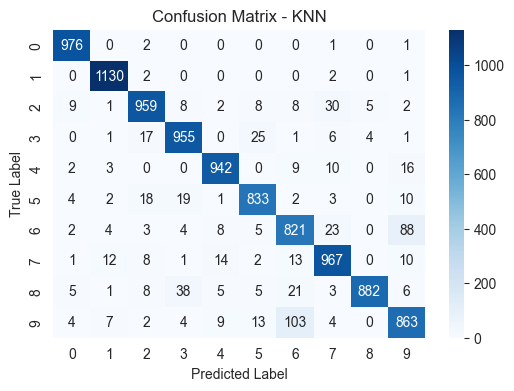

In [36]:
import importlib
import transformations as trans; importlib.reload(trans)

combine_test = []
for i in range(0,len(X_test)):
    combine_test.append(np.append(f_X_test[i], X_test[i]))
combine_train = []
for i in range(0,len(X_train)):
    combine_train.append(np.append(f_X_train[i], X_train[i]))

knn_model_fourier = train_knn(combine_train, Y_train_non_flat, combine_test, Y_test_non_flat, k=3)

In [42]:
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
from sklearn.metrics import *

# distance functions#

def cosine_distance(vec1, vec2):
    return cosine_distances([vec1], [vec2])[0][0]

def euclidean_distance(vec1, vec2):
    return euclidean_distances([vec1], [vec2])[0][0]

def manhattan_distance(vec1, vec2):
    return manhattan_distances([vec1], [vec2])[0][0]

def image_distortion_model_distance(img1, img2):
    """
    Custom IDM distance function.
    img1, img2: Flattened image vectors.
    Returns: IDM-based distance.
    """
    # Reshape to 2D if needed (assuming square images)
    size = int(np.sqrt(len(img1)))  # Assuming square images
    img1 = img1.reshape((size, size))
    img2 = img2.reshape((size, size))

    # IDM Distance Computation (simplified version)
    dist = 0
    for i in range(size):
        for j in range(size):
            local_diffs = [abs(img1[i, j] - img2[i + di, j + dj])
                           for di in range(-1, 2) for dj in range(-1, 2)
                           if 0 <= i + di < size and 0 <= j + dj < size]
            dist += min(local_diffs) if local_diffs else abs(img1[i, j] - img2[i, j])

    return dist


=== KNN With Cosine Distance ===
Accuracy: 0.9733


,precision,recall,f1-score,support
0,0.96,1.00,0.98,980.00
1,0.97,1.00,0.98,1135.00
2,0.98,0.97,0.98,1032.00
3,0.97,0.97,0.97,1010.00
4,0.98,0.96,0.97,982.00
5,0.97,0.96,0.97,892.00
6,0.98,0.99,0.98,958.00
7,0.98,0.97,0.97,1028.00
8,0.98,0.96,0.97,974.00
9,0.95,0.96,0.96,1009.00


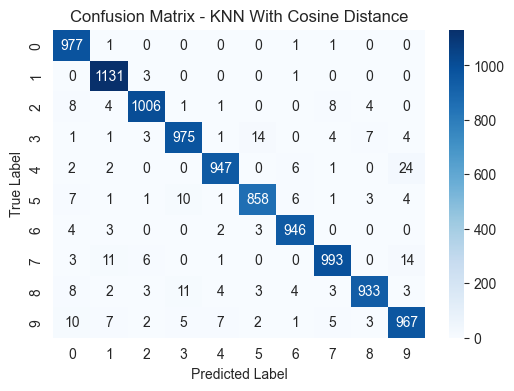

In [38]:
knn_cosine = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn_cosine.fit(X_train, y_train)
y_pred_cosine = knn_cosine.predict(X_test)
display_metrics_and_confusion_matrix("KNN With Cosine Distance", y_test, y_pred_cosine)


=== KNN With Euclidean Distance ===
Accuracy: 0.9705


,precision,recall,f1-score,support
0,0.97,0.99,0.98,980.00
1,0.96,1.00,0.98,1135.00
2,0.98,0.97,0.97,1032.00
3,0.96,0.97,0.96,1010.00
4,0.98,0.97,0.97,982.00
5,0.97,0.96,0.96,892.00
6,0.98,0.99,0.98,958.00
7,0.96,0.96,0.96,1028.00
8,0.99,0.94,0.96,974.00
9,0.96,0.96,0.96,1009.00


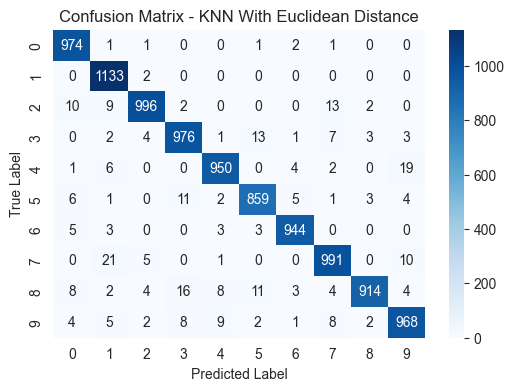

In [39]:

knn_euclidean = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_euclidean.fit(X_train, y_train)
y_pred_euclidean = knn_euclidean.predict(X_test)
display_metrics_and_confusion_matrix("KNN With Euclidean Distance", y_test, y_pred_euclidean)



=== KNN With Manhattan Distance ===
Accuracy: 0.9633


,precision,recall,f1-score,support
0,0.96,0.99,0.98,980.00
1,0.94,1.00,0.97,1135.00
2,0.98,0.95,0.97,1032.00
3,0.96,0.96,0.96,1010.00
4,0.97,0.95,0.96,982.00
5,0.96,0.96,0.96,892.00
6,0.98,0.98,0.98,958.00
7,0.95,0.96,0.95,1028.00
8,0.99,0.92,0.95,974.00
9,0.95,0.95,0.95,1009.00


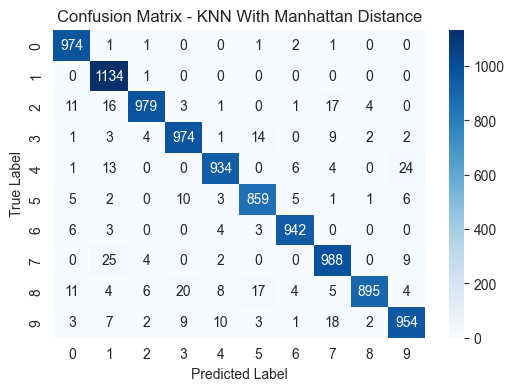

In [40]:
knn_manhattan = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
knn_manhattan.fit(X_train, y_train)
y_pred_manhattan = knn_manhattan.predict(X_test)
display_metrics_and_confusion_matrix("KNN With Manhattan Distance", y_test, y_pred_manhattan)
